# Modelling

In this stage, we will perform modelling on the cleaned dataset to address the objectives set for this study.

1. [[Link to data exploration notebook](./exploration.ipynb)]
2. [[Link to data preprocessing notebook](./preprocessing.ipynb)]

In [178]:
# Install all dependencies
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Gregory\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import Libraries and Dependencies

In [179]:
import sys
sys.path.append('../src/')

In [180]:
# Import libraries
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# For Classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# For Clustering
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Import custom plots
from customPlots.plotting import plot_learning_curve, plot_roc_curve, plot_line

In [181]:
# Load dataset
df = pd.read_csv('../data/cleaned_data.csv', index_col=0)

In [182]:
X = df.drop(['isPaidOff'], axis=1)
y = df['isPaidOff']

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In [183]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30620 entries, 0 to 30619
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   payFrequency          30620 non-null  int64  
 1   apr                   30620 non-null  float64
 2   nPaidOff              30620 non-null  int64  
 3   loanStatus            30620 non-null  int64  
 4   state                 30620 non-null  int64  
 5   leadType              30620 non-null  int64  
 6   leadCost              30620 non-null  float64
 7   fpStatus              30620 non-null  int64  
 8   hasCF                 30620 non-null  int64  
 9   NumPaymentsPaid       30620 non-null  float64
 10  NumPaymentsMissed     30620 non-null  float64
 11  NumPaymentsCancelled  30620 non-null  float64
 12  nLoanTaken            30620 non-null  int64  
 13  earningDiff           30620 non-null  float64
 14  applicationYear       30620 non-null  int64  
dtypes: float64(6), int64(9)


In [184]:
fs = SelectKBest(f_classif, k='all')
fs.fit(X_train, y_train)

fs_score = sorted(list(zip(X.columns,fs.scores_)), key=lambda x: x[1], reverse=True)
print(f'Feature Score:')
for feature, score in fs_score:
  print ("{:<30} {:<20}".format(feature,score))

Feature Score:
NumPaymentsPaid                6109.232956342829   
earningDiff                    5809.366446466725   
loanStatus                     1709.2697078196643  
applicationYear                1233.765846961907   
nLoanTaken                     730.5239855726628   
leadCost                       573.8478954363264   
NumPaymentsCancelled           415.77103680717096  
apr                            410.0577045913732   
hasCF                          177.5218112861216   
NumPaymentsMissed              95.64384369182152   
state                          76.40164368838442   
leadType                       43.83292492427964   
nPaidOff                       0.5446110371549431  
payFrequency                   0.06924525077663414 
fpStatus                       0.03448946938142289 


Selected Features:
- NumPaymentsPaid
- earningDiff
- loanStatus
- applicationYear
- nLoanTaken
- leadCost
- NumPaymentsCancelled
- apr

In [185]:
# Resplit data with the best features
X = df[['NumPaymentsPaid','earningDiff','loanStatus','applicationYear','nLoanTaken','leadCost','NumPaymentsCancelled','apr']]
y = df['isPaidOff']

# scale before modelling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['isPaidOff'], shuffle=True)

## Predictive Modelling

### Objective 1
- To predict the likelihood of a given individual being able to repay their loan based on their payment pattern and profile

In [186]:
# hyperparameters
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scoring = 'f1'

#### Logistic Regression

In [187]:
# Train the model
logit = LogisticRegression()
logit.fit(X_train, y_train)

# Create Prediction
logit_pred = logit.predict(X_test)

# Check performance
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1296
           1       0.97      0.99      0.98      4828

    accuracy                           0.97      6124
   macro avg       0.97      0.94      0.96      6124
weighted avg       0.97      0.97      0.97      6124



In [188]:
scores = cross_val_score(logit, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, logit_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.9823017902813299
CV average score: 0.9837741437023768


array([0.98394495, 0.98089499, 0.98479381, 0.98633316, 0.9829038 ])

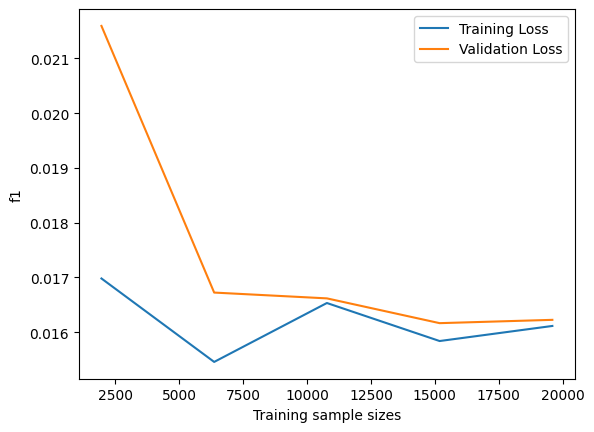

In [189]:
plot_learning_curve(logit, X_train, y_train, cv=cv, scoring=scoring)

#### Decision Tree

In [190]:
# Train the model
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

# Create Prediction
dt_pred = dt_clf.predict(X_test)

# Check performance
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1296
           1       0.99      0.99      0.99      4828

    accuracy                           0.98      6124
   macro avg       0.97      0.97      0.97      6124
weighted avg       0.98      0.98      0.98      6124



In [191]:
scores = cross_val_score(dt_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, dt_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.985603314344899
CV average score: 0.9863295162384855


array([0.98544377, 0.9847269 , 0.98632634, 0.98855954, 0.98659103])

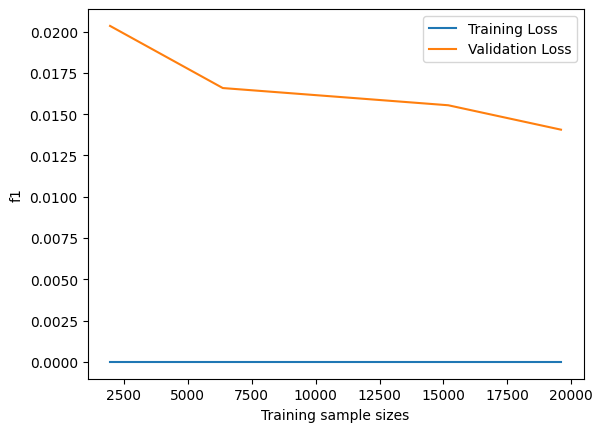

In [192]:
plot_learning_curve(dt_clf, X_train, y_train, cv=cv, scoring=scoring)

#### Support Vector Machine

In [193]:
# Train the model
svc_clf = SVC()
svc_clf.fit(X_train, y_train)

# Create Prediction
svc_pred = svc_clf.predict(X_test)

# Check performance
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1296
           1       0.97      0.99      0.98      4828

    accuracy                           0.97      6124
   macro avg       0.97      0.95      0.96      6124
weighted avg       0.97      0.97      0.97      6124



In [194]:
scores = cross_val_score(svc_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, svc_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.9832871936839948
CV average score: 0.983317340413081


array([0.98342682, 0.98136007, 0.98477026, 0.98452412, 0.98250543])

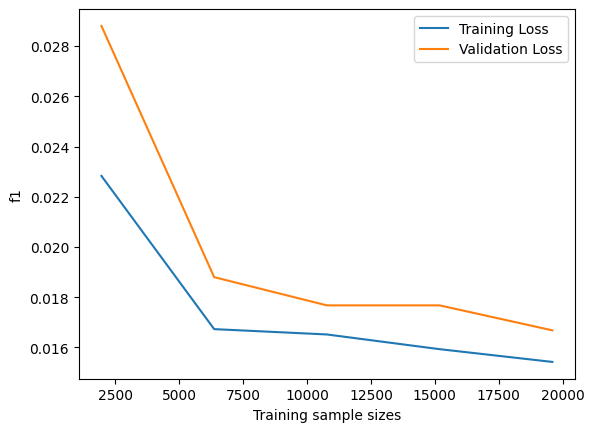

In [195]:
plot_learning_curve(svc_clf, X_train, y_train, cv=cv, scoring=scoring)

#### Naive Bayes

In [196]:
# Train the model
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Create Prediction
nb_pred = nb_clf.predict(X_test)

# Check performance
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1296
           1       0.98      0.93      0.96      4828

    accuracy                           0.94      6124
   macro avg       0.89      0.94      0.91      6124
weighted avg       0.94      0.94      0.94      6124



In [197]:
scores = cross_val_score(nb_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, nb_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.9584617019016254
CV average score: 0.9588072429007326


array([0.95288936, 0.95904255, 0.95914267, 0.95884554, 0.96411609])

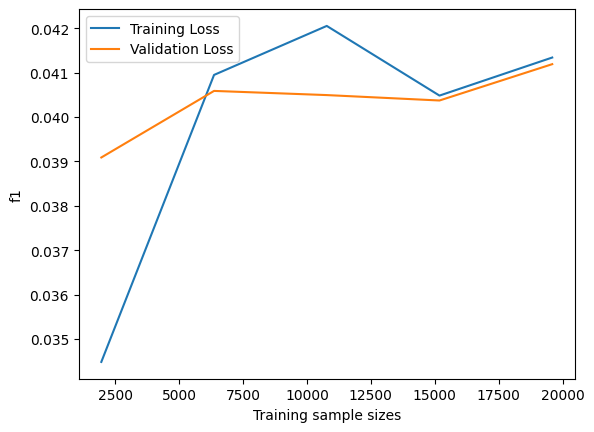

In [198]:
plot_learning_curve(nb_clf, X_train, y_train, cv=cv, scoring=scoring)

#### Random Forest

In [199]:
# Train the model
rfc_clf = RandomForestClassifier()
rfc_clf.fit(X_train, y_train)

# Create Prediction
rfc_pred = rfc_clf.predict(X_test)

# Check performance
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1296
           1       0.98      0.99      0.99      4828

    accuracy                           0.98      6124
   macro avg       0.97      0.96      0.96      6124
weighted avg       0.98      0.98      0.98      6124



In [200]:
scores = cross_val_score(rfc_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, rfc_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.9853909465020576
CV average score: 0.9861606713352462


array([0.98577835, 0.98516703, 0.98755187, 0.98758407, 0.98472204])

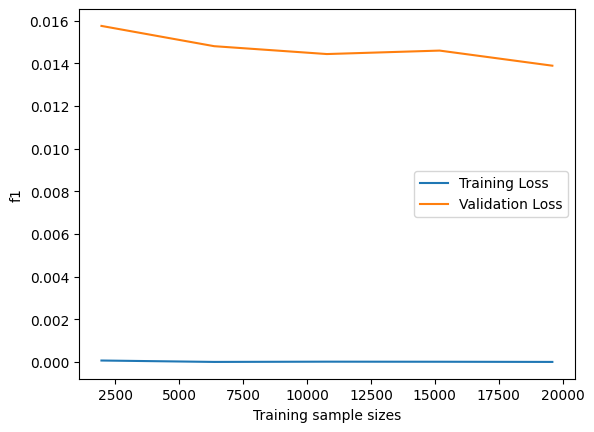

In [201]:
plot_learning_curve(rfc_clf, X_train, y_train, cv=cv, scoring=scoring)

#### XGBoost Classification

In [202]:
# Train the model
xgb_clf= XGBClassifier()
xgb_clf.fit(X_train, y_train)

# Create Prediction
xgb_pred = xgb_clf.predict(X_test)

# Check performance
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1296
           1       0.98      0.99      0.99      4828

    accuracy                           0.98      6124
   macro avg       0.98      0.96      0.97      6124
weighted avg       0.98      0.98      0.98      6124



In [203]:
scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, xgb_pred)}')
print(f'CV average score: {scores.mean()}')
scores

prediction score: 0.9883613142445155
CV average score: 0.9894578483901387


array([0.99051282, 0.98826261, 0.98989375, 0.99094671, 0.98767334])

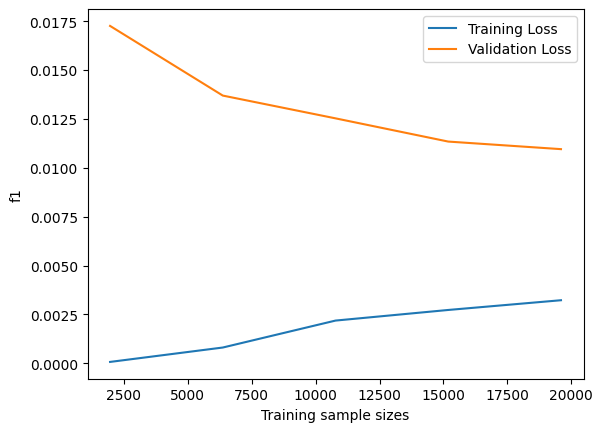

In [204]:
plot_learning_curve(xgb_clf, X_train, y_train, cv=cv, scoring=scoring)

#### LightGBM Classification

In [205]:
# Train the model
lgbm_clf= LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

# Create Prediction
lgbm_pred = lgbm_clf.predict(X_test)

# Check performance
print(classification_report(y_test, lgbm_pred))

[LightGBM] [Info] Number of positive: 19312, number of negative: 5184
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 24496, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.788374 -> initscore=1.315150
[LightGBM] [Info] Start training from score 1.315150
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1296
           1       0.98      0.99      0.99      4828

    accuracy                           0.98      6124
   macro avg       0.98      0.96      0.97      6124
weighted avg       0.98      0.98      0.98      6124



In [206]:
scores = cross_val_score(lgbm_clf, X_train, y_train, cv=cv, scoring=scoring)

print(f'prediction score: {f1_score(y_test, lgbm_pred)}')
print(f'CV average score: {scores.mean()}')
scores

[LightGBM] [Info] Number of positive: 15428, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 19596, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787304 -> initscore=1.308748
[LightGBM] [Info] Start training from score 1.308748
[LightGBM] [Info] Number of positive: 15448, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 19597, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.788284 -> initscore=1.314612
[Ligh

array([0.98718606, 0.98507079, 0.98744337, 0.98824137, 0.98564839])

[LightGBM] [Info] Number of positive: 1521, number of negative: 438
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 1959, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.776417 -> initscore=1.244904
[LightGBM] [Info] Start training from score 1.244904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

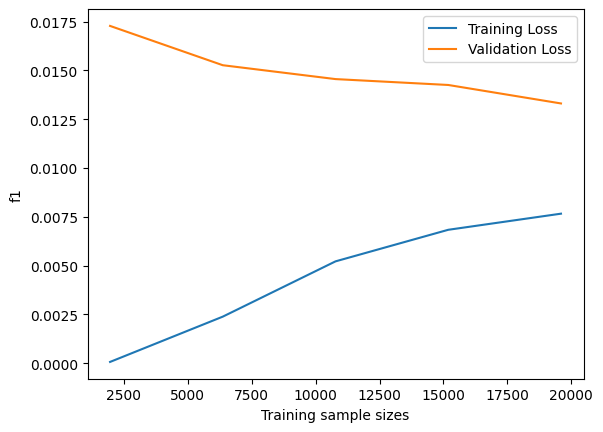

In [207]:
plot_learning_curve(lgbm_clf, X_train, y_train, cv=cv, scoring=scoring)

#### Model Evaluation

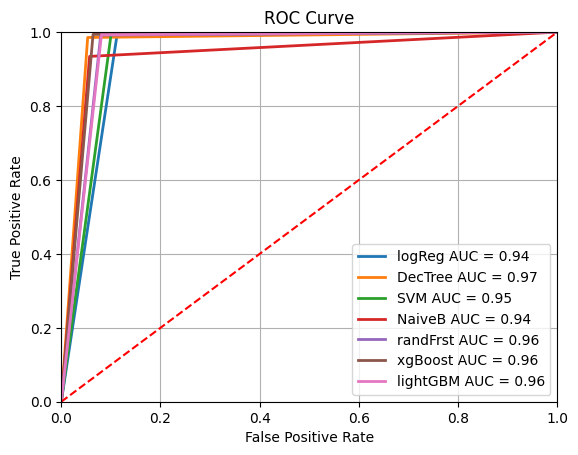

In [208]:
curve_data = [
    ['logReg', logit_pred],
    ['DecTree', dt_pred],
    ['SVM', svc_pred],
    ['NaiveB', nb_pred],
    ['randFrst', rfc_pred],
    ['xgBoost', xgb_pred],
    ['lightGBM', lgbm_pred]  
]

plot_roc_curve(curve_data, y_test)

From the above, the model of choice selected as the best model used in making classification predictions will be the **xgBoost classifier** as it has shown the highest score for f1 and a relatively high AUC score.

### Objective 2

- to identify the customer group with the lowest risk of loan defaults, which the marketing team can put in efforts to target and attract these groups of customer.

#### KMeans Clustering

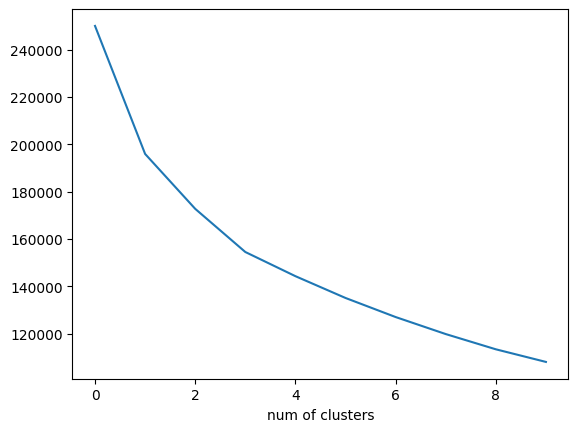

Number of Cluster: 4


In [209]:
# find the most optimal k value
kmeans_df = pd.concat([X, y], axis=1)

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(kmeans_df)
    sse.append(kmeans.inertia_)

plot_line(sse, 'num of clusters')

kl = KneeLocator(range(1,11), sse, curve="convex", direction="decreasing")
print(f'Number of Cluster: {kl.elbow}')

In [210]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(kmeans_df)
cluster = df.groupby(kmeans.labels_)

In [211]:
cluster.mean()

,payFrequency,apr,nPaidOff,loanStatus,state,leadType,leadCost,fpStatus,hasCF,NumPaymentsPaid,NumPaymentsMissed,NumPaymentsCancelled,isPaidOff,nLoanTaken,earningDiff,applicationYear
0,0.970746,9.026589e+06,0.024353,4.151478,23.789861,2.915760,2.590747,3.793077,0.963547,1.662582,0.491653,4.858631,0.604534,1.039210,309.028103,2016.809772
1,1.544218,6.813265e+06,0.024339,5.178836,22.269992,2.143613,1.868165,3.801209,0.861829,14.079063,0.676493,2.807407,0.999093,1.320333,1396.385497,2015.511111
2,1.126747,5.657857e+06,0.021912,4.423309,22.623914,5.843785,-3.431248,3.793729,0.621080,6.030790,0.709105,8.267662,0.973555,2.211371,991.799246,2015.934643
3,1.553440,8.192072e+06,0.027746,2.255459,22.726810,1.699064,1.547720,3.793466,0.844853,2.757593,1.871614,12.835495,0.692005,1.025776,259.670553,2015.637416


In [212]:
cluster.median()

,payFrequency,apr,nPaidOff,loanStatus,state,leadType,leadCost,fpStatus,hasCF,NumPaymentsPaid,NumPaymentsMissed,NumPaymentsCancelled,isPaidOff,nLoanTaken,earningDiff,applicationYear
0,0.0,9.277251e+06,0.0,4.0,28.0,4.0,2.854421,4.0,1.0,1.0,0.0,0.0,1.0,1.0,173.530142,2017.0
1,0.0,9.277251e+06,0.0,5.0,22.0,0.0,2.115318,4.0,1.0,12.0,0.0,0.0,1.0,1.0,1156.539389,2016.0
2,0.0,5.651968e+06,0.0,5.0,22.0,6.0,-3.949745,4.0,1.0,5.0,0.0,8.0,1.0,2.0,802.042856,2016.0
3,0.0,9.277251e+06,0.0,2.0,25.0,0.0,2.115318,4.0,1.0,2.0,2.0,11.0,1.0,1.0,172.636729,2016.0


In [213]:
# Decode LabelEncoder from the .pkl file
with open('../misc/label_encoder_loanStatus.pkl', 'rb') as f:
    label_encoder = pickle.load(f)
{encoded_label: original_label for encoded_label, original_label in enumerate(np.unique(label_encoder))}

{0: 'Charged Off',
 1: 'Charged Off Paid Off',
 2: 'External Collection',
 3: 'Internal Collection',
 4: 'New Loan',
 5: 'Paid Off Loan',
 6: 'Pending Paid Off',
 7: 'Returned Item',
 8: 'Settled Bankruptcy',
 9: 'Settlement Paid Off',
 10: 'Settlement Pending Paid Off'}

**Cluster 1 and 2** represents those groups that are more likely to pay off their loan, whereas **cluster 0 and 3** represents those that are less likely to pay their loans off and is written off or settled.

Therefore upon further examination, the cluster of those that are likely to pay off their loans have the characteristics of:

**(1) : Payment Pattern**
- Lesser number of payments missed
- Lesser number of payments cancelled
- Higher number of payment paid
- Lower loan apr percentage

**(2) : Business Effects**
- Higher returns on investment (earnings)
- Lower Cost in Lead (from bvMandatory and organic)

**(3) : Personal Characteristics**
- Payment Frequency of Biweekly Payment (B)
- Taken multiple loans
- From the state of North Carolina (NC)

This shows that these customers are genuine customers that would like to use this loan feature for good reasons and are willing to pay back the amount owe without having to write it off as bad debts. Since they have shown a history of taken multiple loans (some paid off and some still ongoing) and have low leads effort to attract them to do so. 

Therefore marketing team could enforce a customer loyalty system that attracts these customers to continue using and borrowing loans from Moneylion, like reward system or an even lower apr percentage. 

However further analysis needs to be done on the personality of these groups of customers, as the only data known is that they come from the state of North Carolina, which with more data like education, age, income_level, etc. can help better understand the customer personality.

## Conclusion

In conclusion, I have
1. Created a predictive model that could predict the likelihood of a customer's ability to repay their loan borrowed and achieved an f1 score of 99%. However, in the future, with the actual earnings and fees collected, we could look into predicting the fee charges of a customer looking to borrow a loan, which will lead to a better ability to repay their loan. 

2. Created a clustering model to better identify customer groups with a better chance of repaying their borrowed loans and what their characteristics are like. Hence for future enhancement, more information on the customers can help to better cluster and understand their characteristics and behaviour.

Time spent: 3-4 days (~70 hours)